   # IMDB Movie Rating Prediction

The goal of this assignment is build a model that predicts a movie's average rating from the publicly available IMDB dataset. It is important to state early, that the result of the notebook may change if is re-run, as it is pulling from IMDB's site directly. The website states that the datasets are updated daily.

We will not use every table, as some tables are not relevant to the task, as decided with personal domain knowledge. We will explain which tables are going to be used and why below:

USED:

1. title.basics.tsv.gz - This has all the basic details about the movies, such as name, genre, etc. These are some of the factors that can influence a movie's rating.

2. title.crew.tsv.gz - This has all the director and writer information of the movie. A certain director or writer may make better films than another. 

3. title.principals.tsv.gz - This has all the principal actors and others in the films. Certain actors or cinematographers may attract higher ratings or they are selective in their movie choices.

4. title.ratings.tsv.gz - This has all the scores and will contain the predicted variable

5. name.basics.tsv.gz - This has the information of the actors. It may be interesting see if their notable works have greater score than movies not in the list.

NOT USED:

1. title.akas.tsv.gz - This has the translated titles, which are not necessary to the score. An idea, if time permits, would be to look at the languages to determine where the film was screened

2. title.episode.tsv.gz - This refers to TV episodes only. We are explicitly told to only look at movies. 

## Data Import and Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error

In [2]:
# Uncomment the method desired to load dta

In [3]:
# Load directly from source
raw_name = pd.read_csv('https://datasets.imdbws.com/name.basics.tsv.gz',
                      compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
raw_title = pd.read_csv('https://datasets.imdbws.com/title.basics.tsv.gz',
                       compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
raw_crew = pd.read_csv('https://datasets.imdbws.com/title.crew.tsv.gz',
                      compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
raw_principals = pd.read_csv('https://datasets.imdbws.com/title.principals.tsv.gz',
                            compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
raw_rating = pd.read_csv('https://datasets.imdbws.com/title.ratings.tsv.gz',
                        compression='gzip', header=0, sep='\t').replace('\\N', np.nan)

C:\Users\vucyn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# # If alrady predownloaded csv
# raw_name = pd.read_csv('name.basics.tsv.gz',
#                       compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
# raw_title = pd.read_csv('title.basics.tsv.gz',
#                        compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
# raw_crew = pd.read_csv('title.crew.tsv.gz',
#                       compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
# raw_principals = pd.read_csv('title.principals.tsv.gz',
#                             compression='gzip', header=0, sep='\t').replace('\\N', np.nan)
# raw_rating = pd.read_csv('title.ratings.tsv.gz',
#                         compression='gzip', header=0, sep='\t').replace('\\N', np.nan)

Under the data frame 'raw_title' we see that there are more film types than movies. As a result, we should be filtering that our titles are just 'movies'. Below we see all the available types and counts. Although there are technically a wider definition of movie such as 'short' and 'tv movie' we will just filter to 'movie' for simplicity.

In [5]:
raw_title.groupby('titleType').count()['tconst']

titleType
movie            522910
short            690342
tvEpisode       4152252
tvMiniSeries      26582
tvMovie          122196
tvSeries         167454
tvShort           10267
tvSpecial         22042
video            234573
videoGame         23646
Name: tconst, dtype: int64

In [6]:
# Filter for movies and drop redundant or mostly null columns
movies = raw_title[raw_title['titleType'] == 'movie'].drop(columns=['endYear', 'originalTitle', 'titleType'])

In [7]:
# Left join the ratings table and drop any rows that have no rating
movies = movies.merge(raw_rating, how='left', on='tconst').dropna(subset = ['averageRating'])

In [8]:
# Left join movie directors and writers to the table
movies = movies.merge(raw_crew, how='left', on='tconst')
movies['directors'] = movies['directors'].str.split(',')
movies['writers'] = movies['writers'].str.split(',')

In [9]:
# Left join all other types principal cast
movie_principals = raw_principals.loc[raw_principals['tconst'].isin(movies['tconst'])].drop(columns=['job', 'characters'])

In [10]:
roles = movie_principals.category.unique()
roles

array(['actress', 'actor', 'self', 'director', 'producer',
       'cinematographer', 'composer', 'writer', 'production_designer',
       'editor', 'archive_footage', 'archive_sound'], dtype=object)

Removing archive sound and archive footage because they are not many recorded

In [11]:
movie_principals.groupby('category').count()['tconst']

category
actor                  565538
actress                337959
archive_footage          6620
archive_sound              27
cinematographer        161057
composer               163914
director               243548
editor                 101006
producer               196752
production_designer     23062
self                    60921
writer                 247093
Name: tconst, dtype: int64

In [12]:
roles = ['self', 'producer',
       'cinematographer', 'composer','production_designer',
       'editor']

In [13]:
# Adding actors role to movies
movie_actors = movie_principals[(movie_principals['category'] == 'actor') | 
                                (movie_principals['category'] == 'actress')].groupby('tconst')['nconst'].apply(list).to_frame('actors').reset_index()
movies = movies.merge(movie_actors, how='left', on='tconst')

In [14]:
movies['startYear'] = pd.to_datetime(movies['startYear'], format='%Y')

In [15]:
for i in roles:
    role = movie_principals[movie_principals['category'] == i].groupby('tconst')['nconst'].apply(list).to_frame(i).reset_index()
    movies = movies.merge(role, how='left', on='tconst')
    print(str(i) + ' is added to the movies dataframe')

self is added to the movies dataframe
producer is added to the movies dataframe
cinematographer is added to the movies dataframe
composer is added to the movies dataframe
production_designer is added to the movies dataframe
editor is added to the movies dataframe


In [16]:
# Completed dataframe with all relevant information for prediction
movies.head()

,tconst,primaryTitle,isAdult,startYear,runtimeMinutes,genres,averageRating,numVotes,directors,writers,actors,self,producer,cinematographer,composer,production_designer,editor
0,tt0000009,Miss Jerry,0,1894-01-01,45,Romance,5.5,80.0,[nm0085156],[nm0085156],"[nm0063086, nm0183823]",[nm1309758],NaN,NaN,NaN,NaN,NaN
1,tt0000147,The Corbett-Fitzsimmons Fight,0,1897-01-01,20,"Documentary,News,Sport",5.2,300.0,[nm0714557],NaN,NaN,"[nm0179163, nm0280615, nm4082222, nm4081458, n...",[nm0103755],NaN,NaN,NaN,NaN
2,tt0000335,Soldiers of the Cross,0,1900-01-01,NaN,"Biography,Drama",6.3,39.0,"[nm0675140, nm0095714]",NaN,"[nm1010955, nm1012612, nm1011210, nm1012621, n...",NaN,NaN,NaN,NaN,NaN,NaN
3,tt0000574,The Story of the Kelly Gang,0,1906-01-01,70,"Biography,Crime,Drama",6.2,514.0,[nm0846879],[nm0846879],"[nm0846887, nm0846894, nm3002376, nm0170118]",NaN,"[nm0317210, nm0425854, nm0846911]",[nm0675239],[nm2421834],NaN,NaN
4,tt0000615,Robbery Under Arms,0,1907-01-01,NaN,Drama,4.8,15.0,[nm0533958],"[nm0092809, nm0533958]","[nm3071427, nm0581353, nm0888988, nm0240418, n...",NaN,NaN,[nm0167619],NaN,NaN,NaN


In [17]:
movies['runtimeMinutes'] = movies['runtimeMinutes'].astype(float)

Now that we have all the relevant data in one dataframe, we can start analyzing!

## Exploratory Analysis

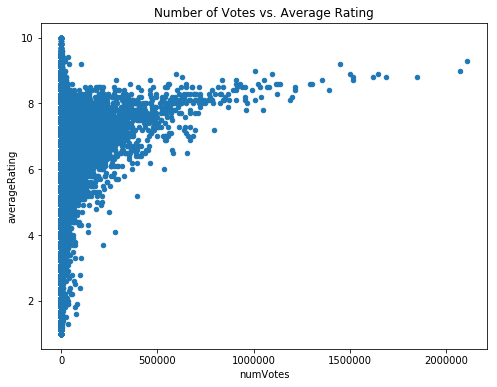

In [18]:
movies.plot.scatter(y='averageRating', x='numVotes', title = 'Number of Votes vs. Average Rating', figsize=(8,6))

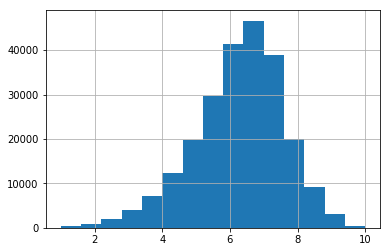

In [19]:
movies.averageRating.hist(bins = 15)

We see an interesting trend that the greater the number of vote, a the higher the confidence will be rated higher on average. In addition, a histogram of the rating shows that the scores are slightly skewed to the left. 

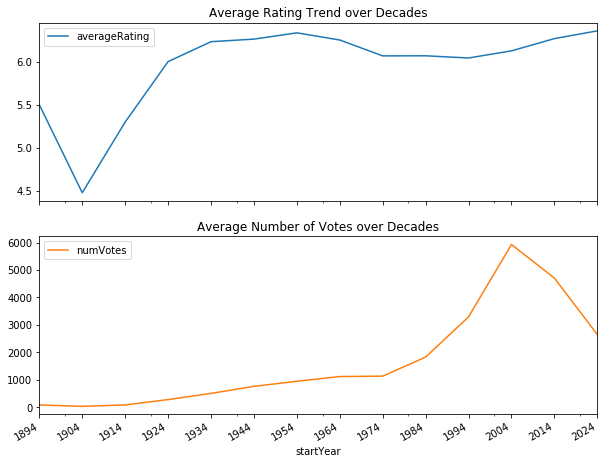

In [20]:
import matplotlib.dates as mdates

decades = movies[['startYear', 'averageRating', 'numVotes']].set_index('startYear').resample('10Y').mean()
decades.index = decades.index.year
ax = decades.plot(subplots=True, layout=(2,1), xticks=decades.index, figsize=(10,8),
                  title = ['Average Rating Trend over Decades', 'Average Number of Votes over Decades'])

We also see that that the average rating and number of votes increase over the years. This may be because are more likely to review movies seen recently. People who are the audience of the older movies may not be review as the internet is new creation. We see a spike in movie reviews in 1970s. 

In [21]:
# Percentage of movies that have at least one genre: 
movies.genres.notnull().sum()/movies.shape[0]
#seems that we can do a pretty good analysis on genre since over 95% have at least just one

0.9525666375308683

In [22]:
genres = movies[['tconst','primaryTitle', 'startYear', 'genres', 'averageRating', 'numVotes']].dropna()
genres['genres'] = genres['genres'].str.split(',')

In [23]:
g = genres.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
g.name = 'genres'
genres = genres.drop('genres', axis=1).join(g)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D9F816F9E8>],
      dtype=object)

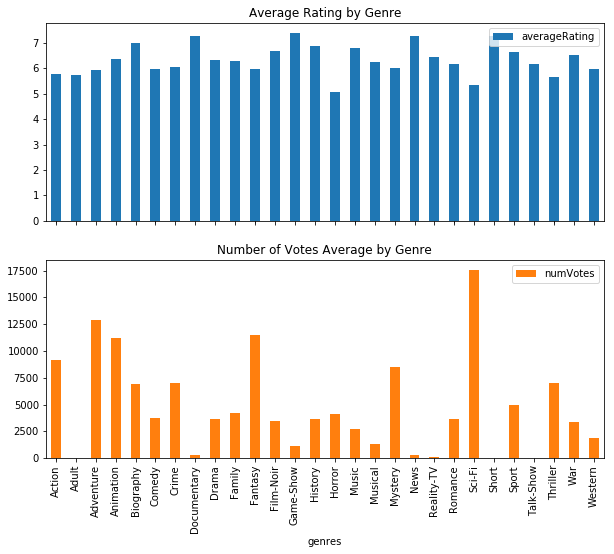

In [24]:
genres.groupby(['genres']).mean().plot.bar(subplots=True, layout=(2,1), figsize=(10,8),
                                           title = ['Average Rating by Genre','Number of Votes Average by Genre'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D9F77D54A8>,
      dtype=object)

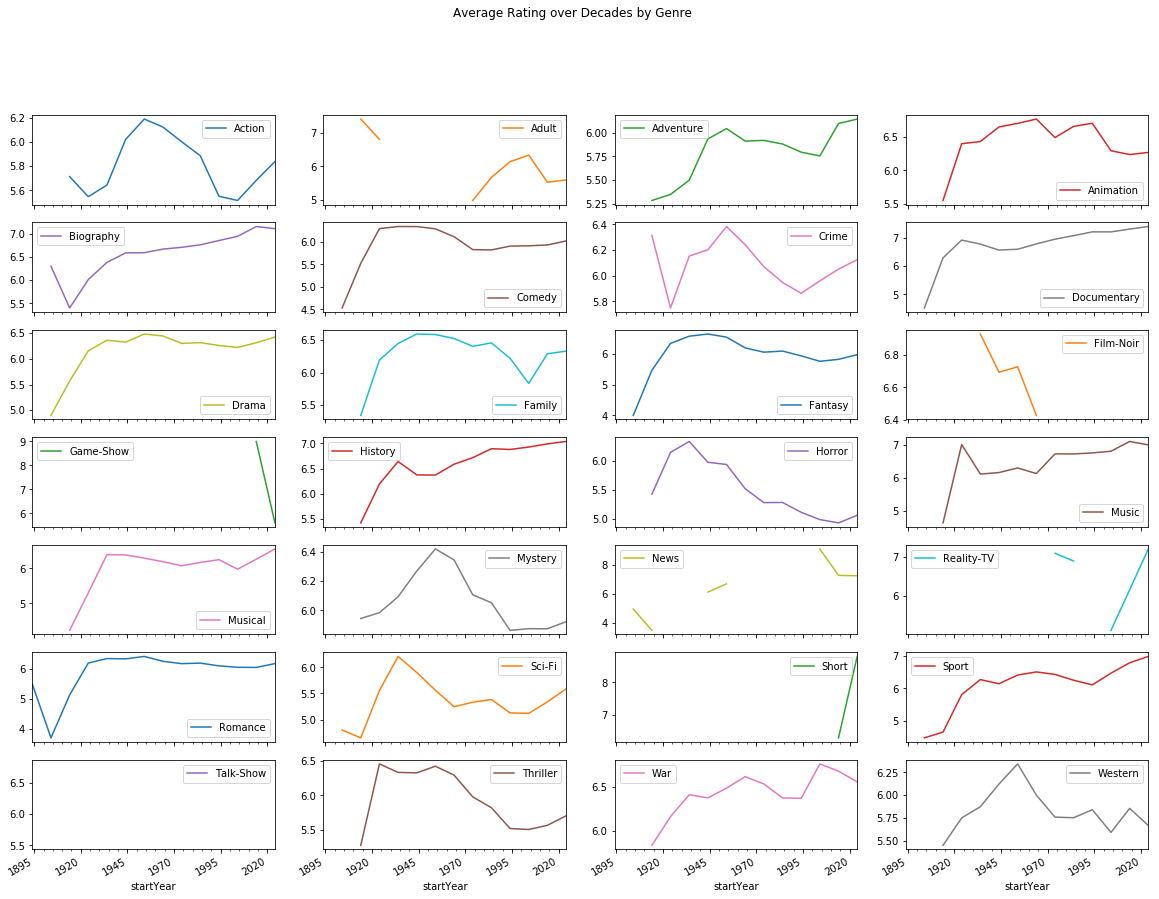

In [25]:
genres.groupby([pd.Grouper(key='startYear', 
                           freq='10Y'),'genres']).mean()['averageRating'].unstack().plot(figsize=(20,15),
                                                                                         subplots=True,
                                                                                         layout = (7,4),
                                                                                         title = 'Average Rating over Decades by Genre')

Seems that adventure, biography, musicals, and documentaries are on an upward trend, while horror, western, and mystery are decreasing in terms of rating

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D9F2AFE518>,
      dtype=object)

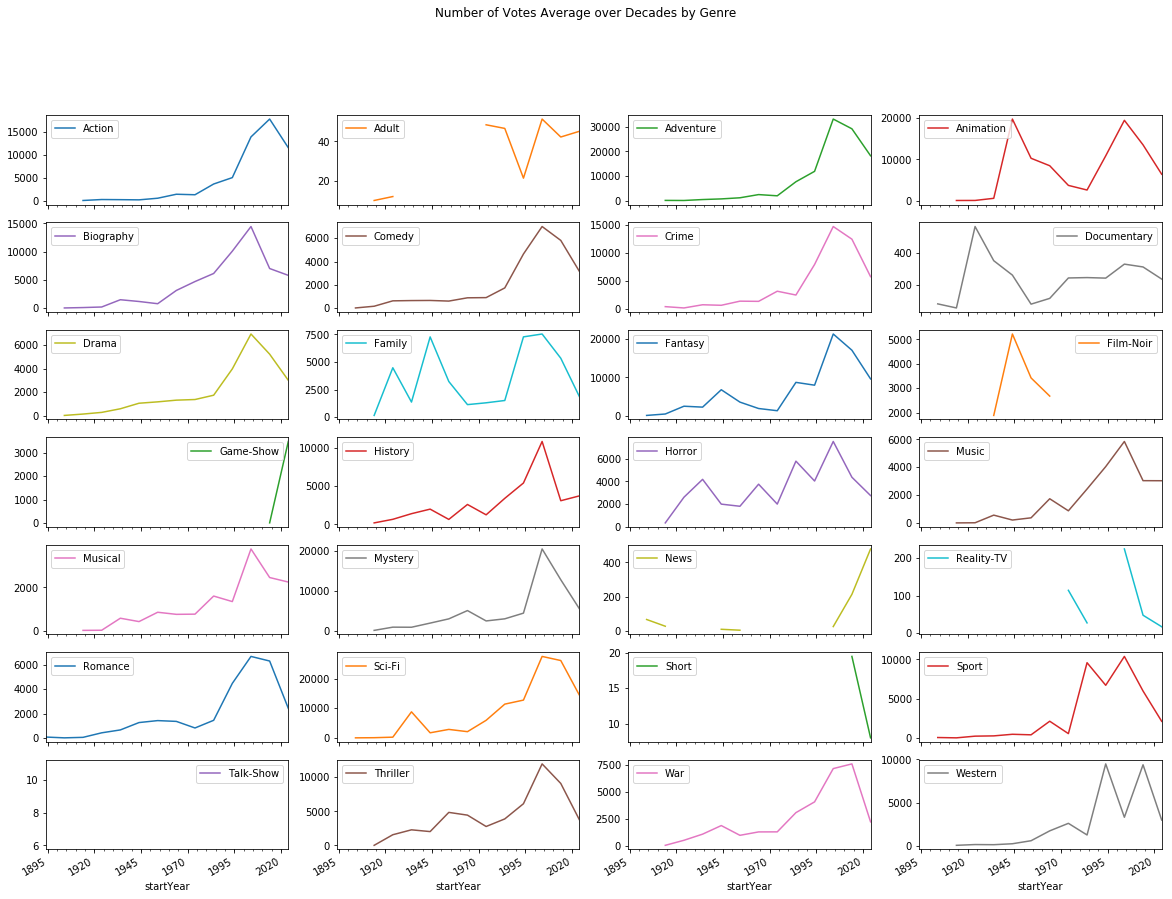

In [26]:
genres.groupby([pd.Grouper(key='startYear', 
                           freq='10Y'),
                'genres']).mean()['numVotes'].unstack().plot(figsize=(20,15),
                                                             subplots=True,
                                                             layout = (7,4),
                                                             title = 'Number of Votes Average over Decades by Genre')

All genres generally have a spike average number of ratings until between 1995 and 2010, and have been decreasing recently.

There are not many numerical data points for correlation testing, but of the ones we were able to showed little results.

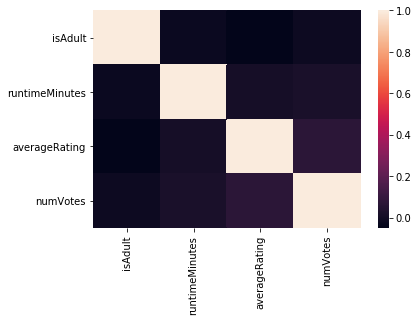

In [27]:
corr = movies.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values)

All of these exploratory analyses have shown a couple of things. The dataset is categorically driven and very complicated in diversity. There are many different and significant artists that could have contributed or detracted from a movie's score. To begin making this prediction model, we must simplify some complicated aspects. 


We will only be looking at the following columns: genre, year, actor, director. 
We will select only the first genre given as the primary genre. We will transform the directors into a binary column, based on number of movies directed (if they directed more or less movies than the average director), and actors into a range based on how many were named as 'principle cast'. The thought behind this is to gauge the big name 'star power' in each category. 

In [115]:
movies_1 = movies[['tconst', 'primaryTitle', 'averageRating', 'numVotes', 'directors', 'actors', 'genres']]
movies_1 = movies_1.dropna()

In [116]:
movies_1['genres'] = movies_1['genres'].str.split(',').str[0]
movies_1['directors'] = movies_1['directors'].str[0]
movies_1['actors_num'] = movies_1.actors.str.len()

In [117]:
director = movies[['directors','primaryTitle', 'tconst']]
d = director.apply(lambda x: pd.Series(x['directors']),axis=1).stack().reset_index(level=1, drop=True)
d.name = 'directors'
director = director.drop('directors', axis=1).join(d)

Gather a list of directors that make more than average number of films to later differentiate in the main movie table.

In [118]:
print('Average numbers of movies by a director: %s'%(director.groupby('directors').count().sort_values(by = 'tconst', ascending=False).mean()['tconst']))

Average numbers of movies by a director: 2.5797990137698203


In [122]:
d_count = director.groupby('directors').count().sort_values(by = 'tconst', ascending=False).reset_index()
d_count_high = d_count[d_count['primaryTitle']>(director.groupby('directors').count().sort_values(by = 'tconst', ascending=False).mean()['tconst'])]['directors']

In [123]:
movies_1['director_movies_number'] = np.where(movies_1['directors'].isin(d_count_high), 'Above Average', 'Below Average') 

In [124]:
movies_1_final = movies_1[['averageRating', 'numVotes', 'genres', 'actors_num', 'director_movies_number']]

In [125]:
# Shuffle dataframe and split for train and test data
movies_1_final = sklearn.utils.shuffle(movies_1_final)

In [127]:
# Grouping together genres to reduce categories
genre_perc = movies_1_final.groupby('genres').count().sort_values(by = ['averageRating'], 
                                                                  ascending=False).reset_index()[['genres',
                                                                                                  'averageRating']]
genre_perc['genre_perc'] = genre_perc['averageRating']/movies_1_final.notnull().sum()['genres']
genre_perc.head(10)
# Only first 4 are greater than 10 percent, all other genres will be 'other'

,genres,averageRating,genre_perc
0,Drama,63230,0.318582
1,Comedy,50533,0.254609
2,Action,24617,0.124032
3,Crime,10559,0.053201
4,Adventure,9350,0.047110
5,Horror,8966,0.045175
6,Documentary,7548,0.038030
7,Biography,3988,0.020093
8,Thriller,3285,0.016551
9,Adult,3186,0.016053


In [128]:
def genre_simplified(x):
    if x in ['Drama', 'Comedy', 'Documentary', 'Action']:
        return x
    else:
        return 'Other'

In [129]:
movies_1_final.head()

,averageRating,numVotes,genres,actors_num,director_movies_number
61241,5.3,533.0,Action,4,Above Average
127929,5.3,127.0,Drama,7,Above Average
167593,7.8,8.0,Documentary,2,Below Average
46515,6.5,12475.0,Comedy,4,Above Average
36142,7.6,19963.0,Comedy,4,Above Average


In [130]:
movies_1_final['genre_simplified'] = movies_1_final['genres'].apply(genre_simplified)

In [131]:
movies_1_final = movies_1_final[['averageRating', 'numVotes', 'actors_num', 'director_movies_number', 'genre_simplified']]
movies_1_final.head()

,averageRating,numVotes,actors_num,director_movies_number,genre_simplified
61241,5.3,533.0,4,Above Average,Action
127929,5.3,127.0,7,Above Average,Drama
167593,7.8,8.0,2,Below Average,Documentary
46515,6.5,12475.0,4,Above Average,Comedy
36142,7.6,19963.0,4,Above Average,Comedy


In [132]:
# Use one hot encoding for categorical data (genre and director above average)

one_hot = pd.get_dummies(movies_1_final[['director_movies_number', 'genre_simplified']])
# Drop column B as it is now encoded
movies_1_final = movies_1_final.drop(columns = ['director_movies_number', 'genre_simplified'], axis = 1)
# Join the encoded df
movies_1_final = movies_1_final.join(one_hot)

In [133]:
train = movies_1_final.iloc[:175000]
test = movies_1_final.iloc[175000:]

In [153]:
X = train.iloc[:,1:]
y = train.iloc[:,0]
test_X = test.iloc[:,1:]
test_y = test.iloc[:,0]

### Fitting and Evaluating the Prediction Model

Although there are many types of models we could use, we are only going to try one model: Random Forest Regression, as this notebook kept on crashing my computer. Actions with more time and suggestions are stated at the end.

In [147]:
# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()
regr.fit(X, y) 
print(regr.feature_importances_)
pred_y = regr.predict(test_X)
# Interesting, this gives confirmation that number of reviews does play a part in predicting rating score

C:\Users\vucyn\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.64989959 0.10136159 0.01885084 0.01786475 0.01194004 0.02047057
 0.08617578 0.08115744 0.0122794 ]


In [155]:
mean_squared_error(test_y, pred_y)
# This means that on average the predictions can be off by sqrt(1.6), which is ~1.3 points.
# There is definitely room for improvement

1.676871821826368

In [ ]:
from sklearn.ensemble import Lin
regr = RandomForestRegressor()
regr.fit(X, y) 
print(regr.feature_importances_)
pred_y = regr.predict(test_X)
# Interesting, this gives confirmation that number of reviews does play a part in predicting rating score

## Things to do with more time

This dataset is very raw and categorically based. With more time, I'd like to add the following:

1. Take in account the synergy between genre combos, such as rom-com, or certain actor-actor/actor-director dynamics. 
2. Add peak star power throughout an actor's lifetime in account. For example, Lauren Bacall starred in many movies in the 40s and 60s. However, during the 80s she starred in a movie that got mixed reviews and she didn't have as much viewer pull with the younger audiences. Actors, directors, and humans have prime periods or bad periods of movie choices. 
3. Have more numerical categories such as profit, theater screened, etc. 
4. In addition, I'd would play around more with the parameters of each model and try different type of regression models. If the models were weak overall, I'd use ensemble methods (such as gradient boost) to boost the results of the multiple weak methods. To verify the effectiveness of the models, I'd use cross validation. 